In [1]:
# 精确积分法求解
# 引入所需要的库
# 作者：Jiajun Du
import math
import numpy as np
import matplotlib.pyplot as plt
# import time
# from tqdm import tqdm,trange
#plt.style.use("ggplot")
plt.rcParams['font.sans-serif'] = ['Microsoft Yahei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# title：绘图标题；ta：地震动时序，a：地震动加速度幅值，t:周期时序，u:位移最大值序列，v，amax分别为速度和加速度最大值序列
from numba import jit

def draw_response(title,ta,a,t,u,v,amax,js,damp):
    size = 20
    plt.figure(title,(18,28))
    plt.subplot(4,1,1)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    plt.plot(ta,a,label=r"输入地震波加速度时程")
    plt.grid(True)
    plt.legend(fontsize=size)
    plt.xlim(0,ta[-1])
    plt.subplot(4,1,2)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    for j in range(js):
        plt.plot(t,u[j,:],label = r"damp=%s" % damp[j])
        plt.xlabel(r"周期（s）",fontsize=size)
        plt.ylabel(r"Sd（m）",fontsize=size)
        plt.grid(True)
        plt.legend(fontsize=size)
        plt.xlim(0,t[-1])
    plt.subplot(4,1,3)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    for j in range(js):
        plt.plot(t,v[j,:],label = r"damp=%s" % damp[j])
        plt.ylabel(r"Sv（m/s）",fontsize=size)
        plt.xlabel(r"周期（s）",fontsize=size)
        plt.grid(True)
        plt.legend(fontsize=size)
        plt.xlim(0,t[-1])
    plt.subplot(4,1,4)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    for j in range(js):
        plt.plot(t,amax[j,:],label = r"damp=%s" % damp[j])
        plt.xlabel(r"周期（s）",fontsize=size)
        plt.ylabel(r"Sa（m/s2）",fontsize=size)
        plt.grid(True)
        plt.legend(fontsize=size)
        plt.xlim(0,t[-1])
    plt.savefig('eqhomework1.svg',dpi=600)
    plt.show()

# 用Newmark方法求解地震动下结构的反应，omg：结构自振圆频率，zeta：结构阻尼比
# ag：地震加速度值，dt：地震步长
@jit(nopython=True)
def solve_sdof_eqwave_nmk(omg,zeta,ag,dt):
    omg2 = omg * omg
    #Newmark方法参数，gama和beta，本取值代表了采用的是线加速度法,如果把beta换成0.25就是平均加速度法
    gama = 0.5
    beta = 1 / 6
    
    c = 2*zeta*omg # 阻尼，除以质量m
    keq = omg2 + gama/(beta*dt)*c + 1/(beta*dt*dt)  #等效刚度
    
    n = len(ag)
    u = np.zeros(n)
    v = np.zeros(n)
    a = np.zeros(n)
    u[0] = 0.0 #初始位移设为0
    v[0] = 0.0 #初始速度设为0
    a[0] = -ag[0]-c*v[0]-omg2*u[0] # 利用运动方程给出时间间隔下的初始加速度
    
    for i in range(n-1):
        peq = (-ag[i+1] + (1/beta/dt/dt+gama/beta/dt*c)*u[i] + (1/beta/dt+(gama/beta-1)*c)*v[i]
               +((1/2/beta-1)+dt*(gama/2/beta-1)*c)*a[i])
        u[i+1] = peq/keq
        v[i+1] = gama/beta/dt*(u[i+1]-u[i])+(1-gama/beta)*v[i]+dt*(1-gama/2/beta)*a[i]
        a[i+1] = -ag[i+1]-c*v[i+1]-omg2*u[i+1]
        
    umax = max(np.abs(u))
    vmax = max(np.abs(v))
    amax = omg2*umax
    return umax,vmax,amax


@jit(nopython=True)
def solve_nigam_jennings(omg, zeta, ag, dnt):
    w = omg
    h = zeta
    dt = dnt
    c = 2*h*w # 阻尼，除以质量m
    wd = math.sqrt(1-h*h) * w
    w2 = w*w
    w3 = w*w*w
    wddt = wd*dt
    swddt = math.sin(wddt)
    cwddt = math.cos(wddt)
    ehwt = math.exp(-h*w*dt)
    hc = h/(math.sqrt(1-h*h))
    a11 = ehwt*(hc*swddt+cwddt)
    a12 = ehwt/wd*swddt
    a21 = -w/(math.sqrt(1-h*h))*ehwt*swddt
    a22 = ehwt*(cwddt-hc*swddt)
    
    hc2 = (2*h*h-1)/(w*w*dt)
    hw3dt = 2*h/w/w/w/dt
    b11 = ehwt*((hc2+h/w)*swddt/wd+(hw3dt+1/w/w)*cwddt)-hw3dt
    b12 = -ehwt*(hc2*swddt/wd+hw3dt*cwddt)-1/w/w+hw3dt
    b21 = ehwt*((hc2+h/w)*(cwddt-hc*swddt)-(hw3dt+1/w/w)*(wd*swddt+h*w*cwddt))+1/w/w/dt
    b22 = -ehwt*(hc2*(cwddt-hc*swddt)-hw3dt*(wd*swddt+h*w*cwddt))-1/w/w/dt
    n = len(ag)
    u = np.zeros(n)
    v = np.zeros(n)
    a = np.zeros(n)
    u[0] = 0.0 #初始位移设为0
    v[0] = 0.0 #初始速度设为0
    a[0] = -ag[0]-c*v[0]-w2*u[0] # 利用运动方程给出时间间隔下的初始加速度
    for i in range(n-1):
        u[i+1] = a11*u[i] + a12*v[i] + b11*ag[i] + b12*ag[i+1]
        v[i+1] = a21*u[i] + a22*v[i] + b21*ag[i] + b22*ag[i+1]
        
    umax = max(np.abs(u))
    vmax = max(np.abs(v))
    amax = w2*umax
    return umax,vmax,amax

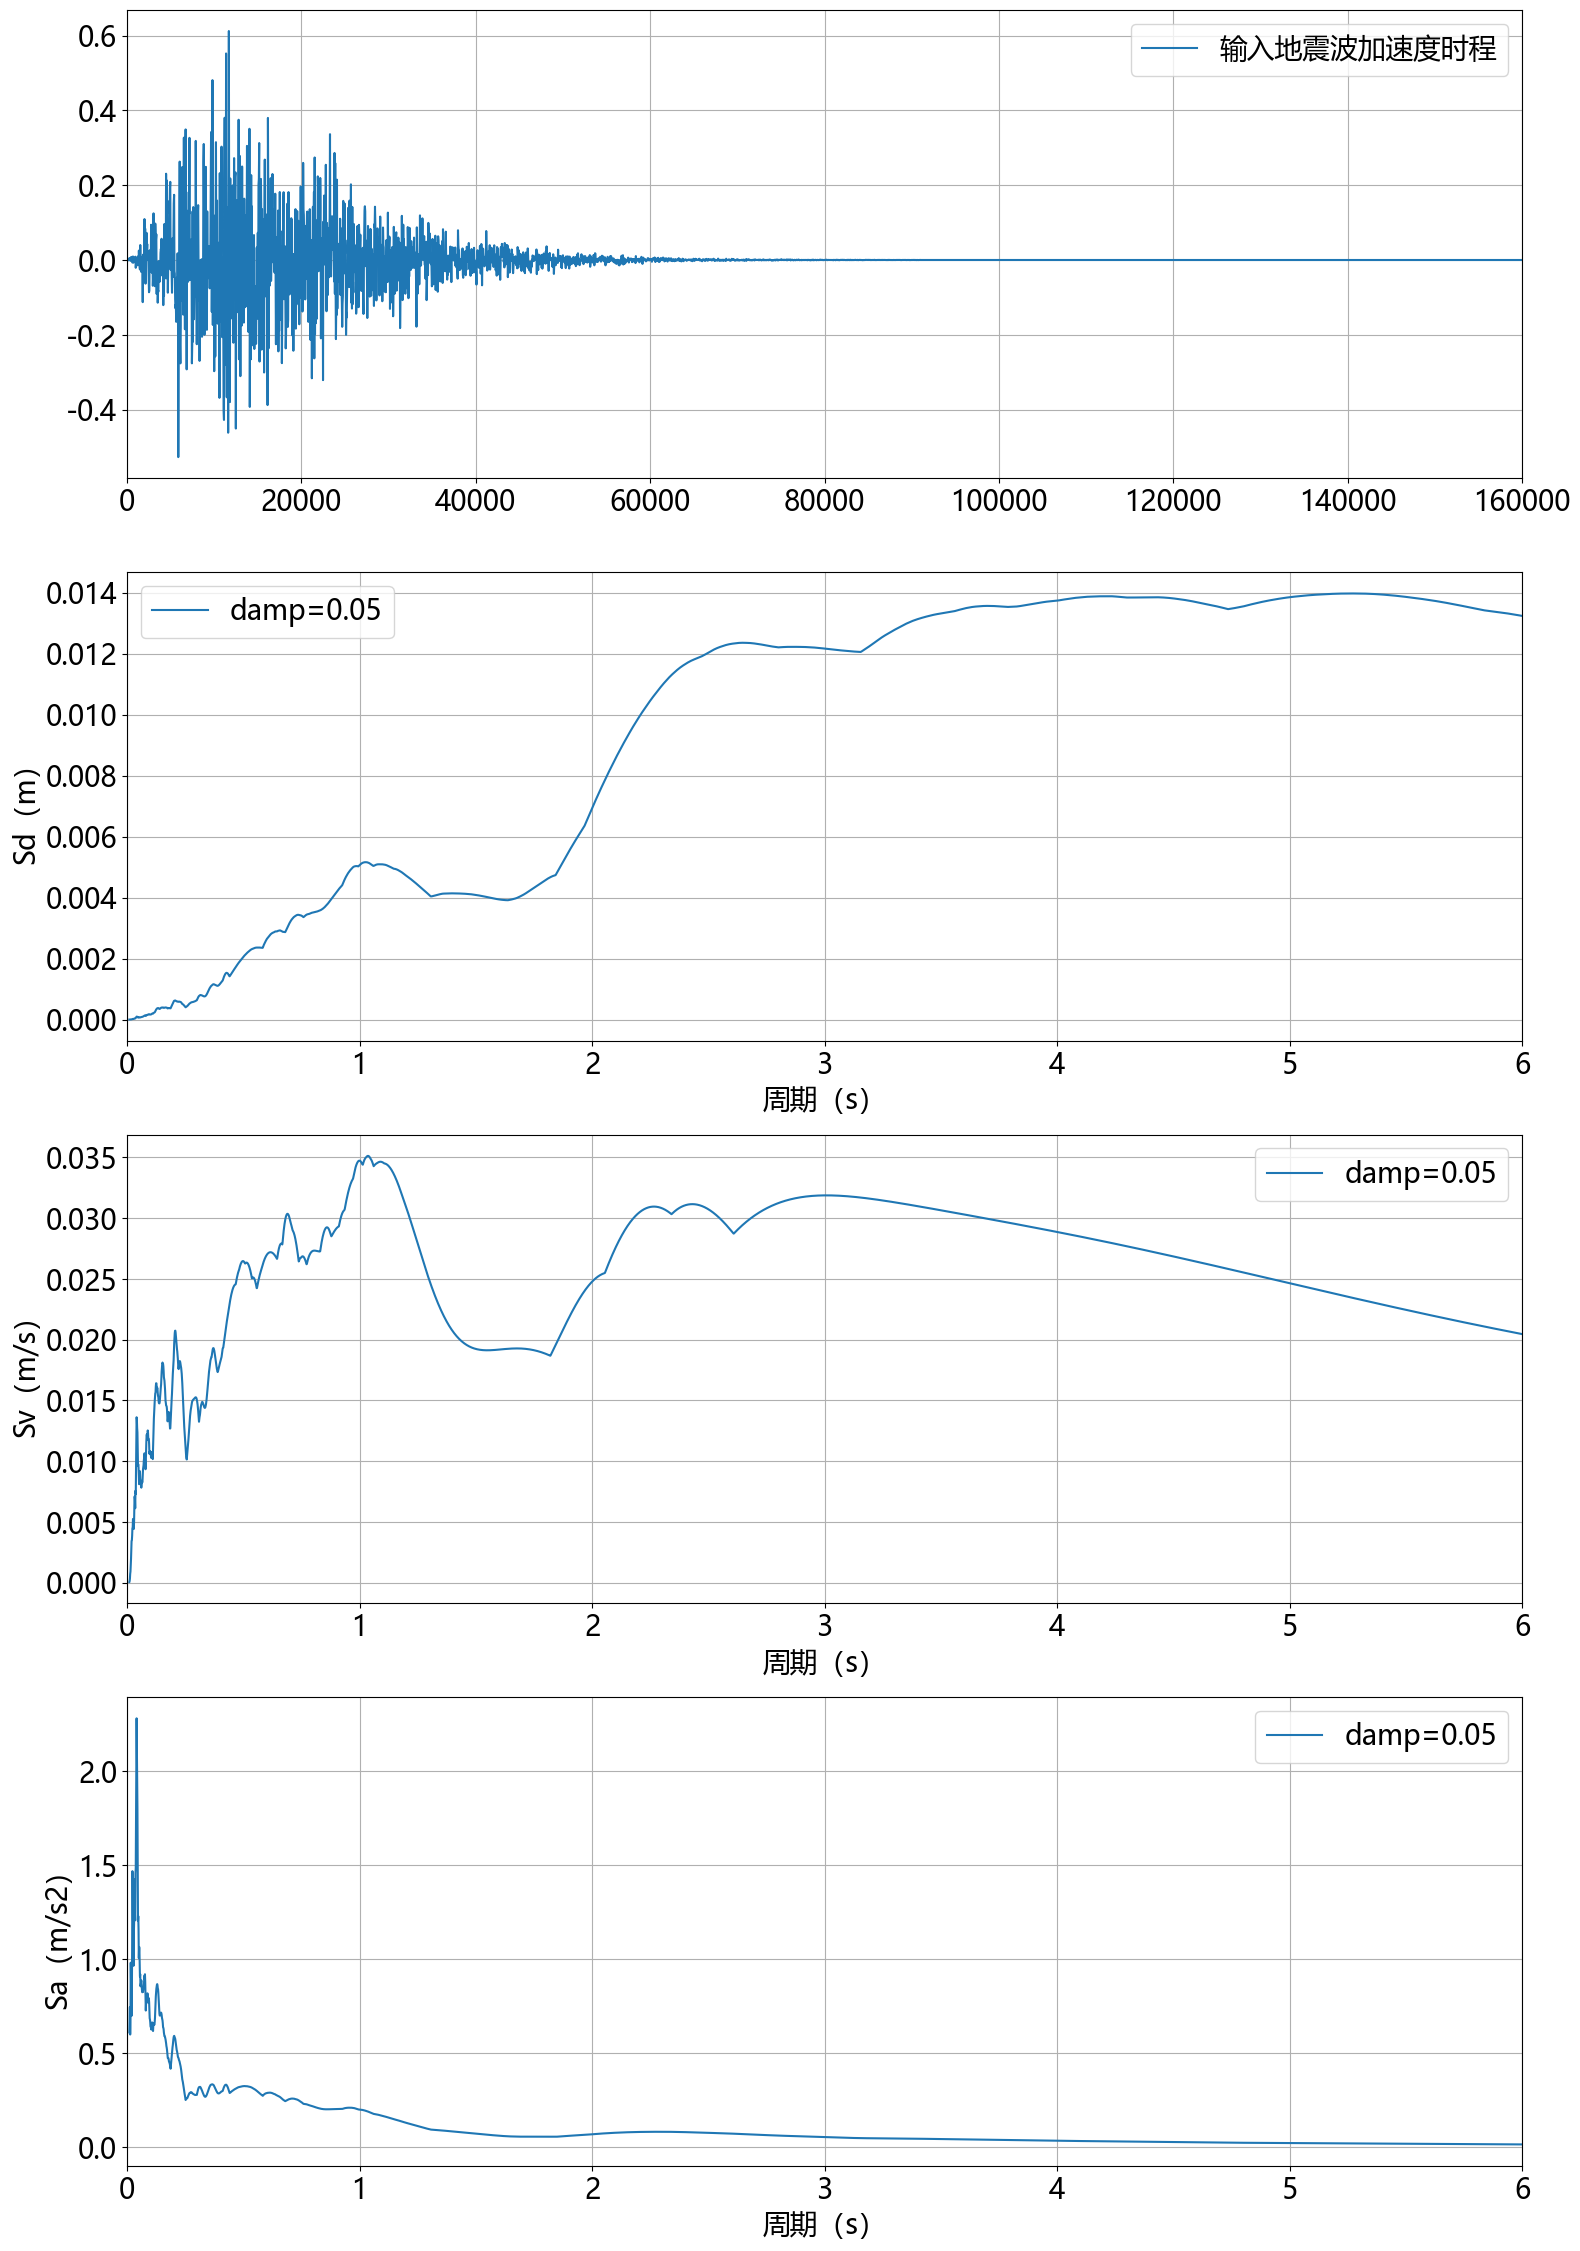

In [3]:
import pandas as pd
from StochasticGroundMotionModeling import StochasticGroundMotionModeling
if __name__ == '__main__':
    # File_data = pd.read_excel('Elcentro加速度曲线.xlsx')
    # df = File_data
    # X = df.loc[:,['时间','加速度']]
    # #t = df.loc[:,['时间']]
    # acc_0 = df.loc[:,['加速度']]
    
    # Stochastic Model
    acc0, dt = StochasticGroundMotionModeling(6.61, 19.3, 602)
    
    # acc0 = np.array(acc_0)
    # acc0 = acc0/100
    acc0 = acc0 * 9.8
    # dt = 0.02
    # dt = 0.01
    n = len(acc0)
    t0 = np.linspace(0.0,dt*(n-1),n)
    ag = acc0
    dnt=0.01
    # zetas = [0.01,0.02,0.03,0.04,0.05,0.1]
    zetas = [0.05]
    
    num = 5000
    row = len(zetas)
    umax = np.zeros((row,num))
    vmax = np.zeros((row,num))
    amax = np.zeros((row,num))
    T = np.linspace(0.01,6.00,num)  #支持更高精度
    j=0
    for zeta in zetas: 
        i = 0
        for T1 in T:
            omg = 2.0*np.pi/T1
            umax[j][i], vmax[j][i], amax[j][i] = solve_nigam_jennings(omg, zeta, ag, dnt) #此处的dnt应该是迭代步长
            i = i+1
        j += 1 
    draw_response("Seismic Response -- nmk", t0, acc0, T, umax,vmax,amax,j,zetas) # 绘图

In [4]:
t = np.arange(0, 40 + 0.01, 0.01)
t.shape

(4001,)